In [1]:
!pip install -q lightgbm optuna shap joblib sqlalchemy psycopg2-binary
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report
import lightgbm as lgb
import optuna
import shap
import joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 19.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/Analytics_loan_collection_dataset.csv"  # <-- change to your dataset path
MODEL_OUTPUT_PATH = "/content/drive/MyDrive/Colab Notebooks/loan_default_predictor.pkl"
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}. Update DATA_PATH in the cell.")

df = pd.read_csv(DATA_PATH)
print(f"Loaded dataset with shape: {df.shape}")

Mounted at /content/drive
Loaded dataset with shape: (2000, 19)


In [3]:
TARGET_COL = 'Target'
if TARGET_COL not in df.columns:
    raise KeyError(f"Target column '{TARGET_COL}' not found in dataset columns: {df.columns.tolist()}.")

# Drop obvious identifier columns if they exist
ID_COLS = [c for c in ['CustomerID', 'customer_id', 'id'] if c in df.columns]
if ID_COLS:
    print('Dropping identifier columns:', ID_COLS)
    df.drop(columns=ID_COLS, inplace=True)

Dropping identifier columns: ['CustomerID']


In [4]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove target from num_cols if present
if TARGET_COL in num_cols:
    num_cols.remove(TARGET_COL)

# Fill numerics
for c in num_cols:
    if df[c].isna().sum() > 0:
        df[c].fillna(df[c].median(), inplace=True)

# Fill categoricals
for c in cat_cols:
    df[c].fillna('missing', inplace=True)

# If SentimentScore exists and is out of expected range, clip it
if 'SentimentScore' in df.columns:
    df['SentimentScore'] = pd.to_numeric(df['SentimentScore'], errors='coerce').fillna(0)
    df['SentimentScore'] = df['SentimentScore'].clip(-1, 1)

In [5]:
# Ensure these columns exist before creating derived features, otherwise skip
cols = df.columns

# BehaviorScore: combination of app usage and website visits vs complaints
if all(c in cols for c in ['AppUsageFrequency', 'WebsiteVisits', 'Complaints']):
    df['BehaviorScore'] = df['AppUsageFrequency'].fillna(0) + df['WebsiteVisits'].fillna(0) - df['Complaints'].fillna(0)

# PaymentRisk: product of missed payments and delay days (plus 1 to avoid zeroing)
if all(c in cols for c in ['MissedPayments', 'DelaysDays', 'PartialPayments']):
    df['PaymentRisk'] = df['MissedPayments'].fillna(0) * df['DelaysDays'].fillna(0) * (1 + df['PartialPayments'].fillna(0))

# SentimentTrend placeholder - if you have historical sentiment per customer, compute change; otherwise keep same
# If you have time-series per customer loaded separately, compute trend and merge here. For single-row-per-customer data, skip.

# Common ratio features
if 'LoanAmount' in cols and 'Income' in cols:
    df['LoanToIncome'] = df['LoanAmount'].replace(0, np.nan) / df['Income'].replace(0, np.nan)
    df['LoanToIncome'].fillna(df['LoanToIncome'].median(), inplace=True)

# Clip extreme outliers in Income and LoanAmount using quantiles
for c in ['Income', 'LoanAmount']:
    if c in df.columns:
        low, high = df[c].quantile([0.01, 0.99]).values
        df[c] = df[c].clip(low, high)

In [6]:
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(int)

# Identify categorical features - prefer a whitelist from the original dataset
categorical_features = [c for c in X.columns if c in ['Location', 'EmploymentStatus', 'LoanType', 'SomeOtherCat'] or X[c].dtype == 'object']
# Remove any accidental numeric-like object columns from categorical list if too many
categorical_features = [c for c in categorical_features if c in X.columns]

print('Categorical features detected:', categorical_features)

# Convert categorical columns to category dtype for LightGBM
for c in categorical_features:
    X[c] = X[c].astype('category')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Categorical features detected: ['Location', 'EmploymentStatus', 'LoanType']
Train shape: (1600, 20) Test shape: (400, 20)


In [7]:
from lightgbm import early_stopping

def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 16, 512),
        'max_depth': trial.suggest_int('max_depth', 3, 16),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 5.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 5.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 200)
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []
    for tr_idx, va_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[va_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        model = lgb.LGBMClassifier(**param, n_estimators=2000)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric='auc',
            categorical_feature=categorical_features,
            callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
        )

        aucs.append(roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]))

    return np.mean(aucs)

# Run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, show_progress_bar=True)
print('Best params:', study.best_params)

[I 2025-08-14 19:58:16,591] A new study created in memory with name: no-name-49c882f4-3346-4ba8-845a-112f4b16c096


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-08-14 19:58:18,515] Trial 0 finished with value: 0.9219873437445891 and parameters: {'learning_rate': 0.04558906531341613, 'num_leaves': 372, 'max_depth': 10, 'feature_fraction': 0.507042418629431, 'bagging_fraction': 0.9300819639796086, 'bagging_freq': 5, 'lambda_l1': 2.840383093789441, 'lambda_l2': 0.028267646488712717, 'min_data_in_leaf': 9}. Best is trial 0 with value: 0.9219873437445891.
[I 2025-08-14 19:58:20,012] Trial 1 finished with value: 0.8328223307648844 and parameters: {'learning_rate': 0.061878211923085076, 'num_leaves': 430, 'max_depth': 9, 'feature_fraction': 0.9906198052705734, 'bagging_fraction': 0.7483210430826668, 'bagging_freq': 9, 'lambda_l1': 4.954914244005538, 'lambda_l2': 0.8493252459478623, 'min_data_in_leaf': 127}. Best is trial 0 with value: 0.9219873437445891.
[I 2025-08-14 19:58:23,139] Trial 2 finished with value: 0.9338423674340162 and parameters: {'learning_rate': 0.03682973297746654, 'num_leaves': 35, 'max_depth': 9, 'feature_fraction': 0.7786

In [8]:
# Model Training
from lightgbm import early_stopping

final_model = lgb.LGBMClassifier(**study.best_params, n_estimators=2000)
final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    categorical_feature=categorical_features,
    callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
)

LGBMClassifier(bagging_fraction=0.7109464273200312, bagging_freq=6,
               feature_fraction=0.7961433234288422,
               lambda_l1=0.3236368424838583, lambda_l2=0.31825220512372443,
               learning_rate=0.04310088584390562, max_depth=12,
               min_data_in_leaf=19, n_estimators=2000, num_leaves=96)

In [9]:
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

y_pred_proba = final_model.predict_proba(X_test)
y_pred = y_pred_proba.argmax(axis=1) if y_pred_proba.shape[1] > 2 else (y_pred_proba[:, 1] >= 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print("Final Evaluation Metrics:")
print(report_df)
print(f"\nAccuracy of our model: {accuracy*100:.2f}%")

Final Evaluation Metrics:
              precision    recall  f1-score   support
0              0.930693  0.926108  0.928395  203.0000
1              0.924242  0.928934  0.926582  197.0000
accuracy       0.927500  0.927500  0.927500    0.9275
macro avg      0.927468  0.927521  0.927489  400.0000
weighted avg   0.927516  0.927500  0.927502  400.0000

Accuracy of our model: 92.75%


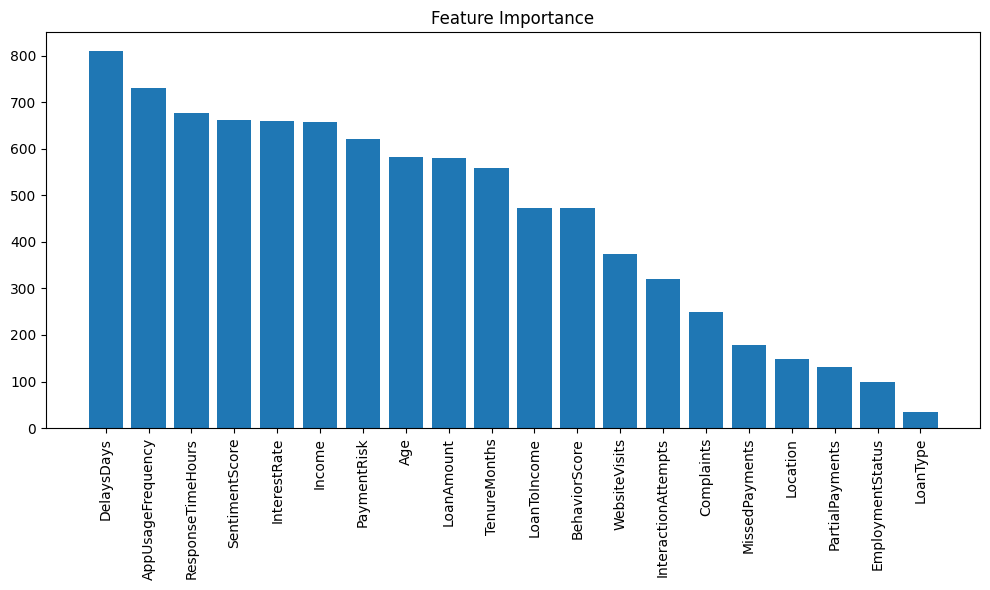

In [10]:
# 1.1 Feature Importance Plot
import matplotlib.pyplot as plt
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

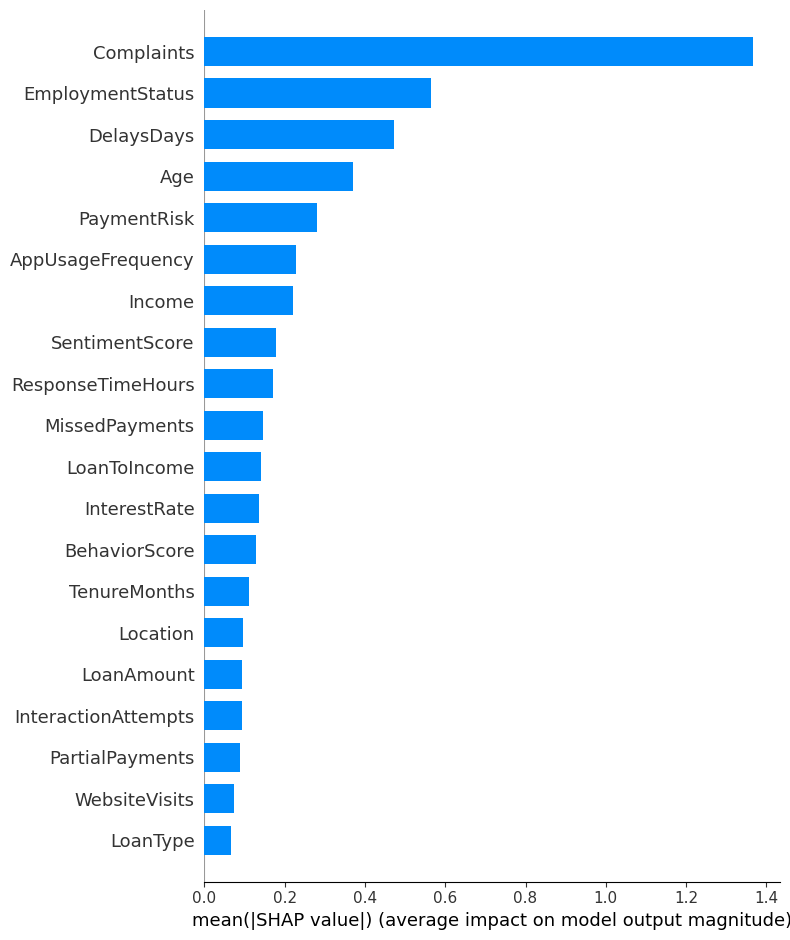

In [11]:
import shap
explainer = shap.TreeExplainer(final_model)

# Ensure categorical columns are numeric to match training format exactly
X_shap = X_test.copy()
for c in categorical_features:
    if str(X_shap[c].dtype) == 'category':
        X_shap[c] = X_shap[c].cat.codes
    elif X_shap[c].dtype == 'object':
        X_shap[c] = X_shap[c].astype('category').cat.codes

# Convert to numpy array to fully drop pandas category tracking
X_shap_array = X_shap.values

shap_values = explainer.shap_values(X_shap_array)
shap.summary_plot(shap_values, X_shap, plot_type='bar')

In [14]:
import joblib
import os

drive_path = '/content/drive/MyDrive/loan_default_predictor.pkl'
local_path = 'loan_default_predictor.pkl'

joblib.dump({'model': final_model, 'features': X_train.columns.tolist(), 'categorical': categorical_features}, local_path)
print(f'Model saved locally to {local_path}')

# If Google Drive is available, copy it there
ios_path_exists = os.path.exists('/content/drive')
if ios_path_exists:
    import shutil
    shutil.copy(local_path, drive_path)
    print(f'Model also saved to Google Drive: {drive_path}')
else:
    print("Google Drive not mounted. Model only saved locally.")

Model saved locally to loan_default_predictor.pkl
Model also saved to Google Drive: /content/drive/MyDrive/loan_default_predictor.pkl
